In [1]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import signature_constants
import tensorflow_addons as tfa
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

tfa.register.register_all()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=768)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
output_saved_model_dir = "./config/hfnet_v2_trt" 
verify_images_path= "/ssd/drone_data_process/images"

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (400, 208))
        if img is not None:
            images.append(img)
    return images
images = load_images_from_folder(verify_images_path)
print(f"Load {len(images)} images")

1 Physical GPUs, 1 Logical GPUs
Load 5735 images


--- Loading Graph 11.945975065231323 seconds ---
First Try
--- First trial 35.32553815841675 seconds ---
Img 2 cost 519.6535587310791ms
Img 4 cost 491.49250984191895ms
Img 6 cost 480.66186904907227ms
Img 8 cost 496.22106552124023ms
Img 9 cost 501.48701667785645ms
Img 14 cost 484.07936096191406ms
Img 15 cost 481.5216064453125ms
Img 16 cost 469.04993057250977ms
Img 17 cost 475.53539276123047ms
Img 18 cost 514.2731666564941ms
Img 20 cost 489.774227142334ms
Img 23 cost 489.8693561553955ms
Img 25 cost 474.7805595397949ms
Img 28 cost 475.7225513458252ms
Img 30 cost 489.0787601470947ms
Img 32 cost 469.09475326538086ms
Img 33 cost 491.0292625427246ms
Img 37 cost 483.6883544921875ms
Img 41 cost 477.71263122558594ms
Img 45 cost 487.7145290374756ms
Img 46 cost 473.58250617980957ms
Img 47 cost 473.6354351043701ms
Img 48 cost 471.88782691955566ms
Img 49 cost 500.06604194641113ms
Img 51 cost 468.4929847717285ms
Img 54 cost 490.07201194763184ms
Img 62 cost 471.51756286621094ms
Img 68 cost 475.5408763

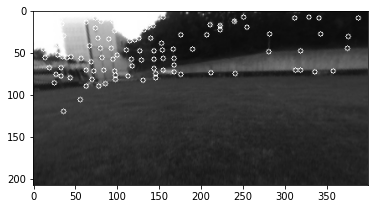

In [2]:
start_time = time.time()

def load():
    saved_model_loaded = tf.saved_model.load(
        output_saved_model_dir, tags=[tag_constants.SERVING])

    frozen_func = graph_func = saved_model_loaded.signatures[
       signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    return frozen_func
def run(img):
    _img = np.expand_dims(img, axis=2)
    _img = np.array([_img]).astype(np.float)
    _img = tf.convert_to_tensor(_img, dtype=tf.float32)
    #print(_img.shape)
    output = frozen_func(_img)
    return output

def draw(img, ret):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    kps = ret["keypoints"][0].numpy()
    for kp in kps:
        img = cv2.circle(img, (kp[0], kp[1]), 3, (255, 255, 255))
    plt.imshow(img)
    plt.show()

frozen_func = load()
print("--- Loading Graph %s seconds ---" % (time.time() - start_time))

print("First Try")
start_time = time.time()
ret = run(images[0])
print("--- First trial %s seconds ---" % (time.time() - start_time))

start_time = time.time()

for i in range(0, len(images)):
    _time = time.time()
    ret = run(images[i])
    if (time.time() - _time > 0.1):
        print(f"Img {i} cost {(time.time() - _time)*1000}ms")
        #draw(images[i], ret)
        
print(f"--- Try {len(images)} images, average {(time.time() - start_time)/len(images)*1000} ms ---")
        
ret = run(images[0])

img = cv2.cvtColor(images[0], cv2.COLOR_GRAY2RGB)
kps = ret["keypoints"][0].numpy()
for kp in kps:
    img = cv2.circle(img, (kp[0], kp[1]), 3, (255, 255, 255))
plt.imshow(img)